In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import imageio
from modified_seismic_CPML_2D_pressure_second_order_functions import *

In [2]:
# Flags para agregar capas PML a los bordes de la malla
USE_PML_XMIN = True
USE_PML_XMAX = True
USE_PML_YMIN = True
USE_PML_YMAX = True

# Número total de puntos de la malla en cada dirección de la malla
NX = 301
NY = 301

# Tamaño de una celda de la malla
DELTAX = 5.0
DELTAY = DELTAX

# Grosor de la capa PML en puntos de la malla
NPOINTS_PML = 10

# Velocidad de P y densidad
cp_unrelaxed = 2500.0
density = 2200.0

# Número total de pasos de tiempo
NSTEP = 8_001

# Paso de tiempo en segundos
DELTAT = 0.0001 

# Parámetros para la fuente
f0 = 20.0
t0 = 1.2 / f0
factor = 1e+4

# Fuente (en presión)
xsource = 750.0
ysource = 70#750.0
ISOURCE = int(xsource / DELTAX) + 1
JSOURCE = int(ysource / DELTAY) + 1

# Receptores
NREC = 1
xdeb = 2301.0  # primer receptor x en metros
ydeb = 2301.0  # primer receptor y en metros
xfin = 2301.0  # último receptor x en metros
yfin = 2301.0  # último receptor y en metros

# Información de visualización en la pantalla de vez en cuando
IT_DISPLAY = 100

# Cero
ZERO = 0.0

# Valor grande para máximo
HUGEVAL = 1.0e+30

# Umbral por encima del cual consideramos que el código se vuelve inestable
STABILITY_THRESHOLD = 1.0e+25

# Inicializar matrices con precisión doble
pressure_past = np.zeros((NX, NY), dtype=np.float64)
pressure_present = np.zeros((NX, NY), dtype=np.float64)
pressure_future = np.zeros((NX, NY), dtype=np.float64)
pressure_xx = np.zeros((NX, NY), dtype=np.float64)
pressure_yy = np.zeros((NX, NY), dtype=np.float64)
dpressurexx_dx = np.zeros((NX, NY), dtype=np.float64)
dpressureyy_dy = np.zeros((NX, NY), dtype=np.float64)
kappa_unrelaxed = np.zeros((NX, NY), dtype=np.float64)
rho = np.zeros((NX, NY), dtype=np.float64)
Kronecker_source = np.zeros((NX, NY), dtype=np.float64)

# Para interpolar parámetros del material o velocidad en la ubicación correcta en la celda de la malla escalonada
rho_half_x = 0.0
rho_half_y = 0.0

# Potencia para calcular el perfil d0
NPOWER = 2.0

# Parámetros PML
K_MAX_PML = 1.0
ALPHA_MAX_PML = 2.0 * np.pi * (f0 / 2.0)

# Arrays para las variables de memoria
memory_dpressure_dx = np.zeros((NX, NY))
memory_dpressure_dy = np.zeros((NX, NY))
memory_dpressurexx_dx = np.zeros((NX, NY))
memory_dpressureyy_dy = np.zeros((NX, NY))

value_dpressure_dx = 0.0 # Valor de la derivada de la presión en x
value_dpressure_dy = 0.0 # Valor de la derivada de la presión en y
value_dpressurexx_dx = 0.0 # Valor de la derivada de la presión en x
value_dpressureyy_dy = 0.0 # Valor de la derivada de la presión en y

# Arrays 1D para los perfiles de amortiguamiento
d_x = np.zeros(NX)
K_x = np.ones(NX)
alpha_x = np.zeros(NX)
a_x = np.zeros(NX)
b_x = np.zeros(NX)
d_x_half = np.zeros(NX)
K_x_half = np.ones(NX)
alpha_x_half = np.zeros(NX)
a_x_half = np.zeros(NX)
b_x_half = np.zeros(NX)

d_y = np.zeros(NY)
K_y = np.ones(NY)
alpha_y = np.zeros(NY)
a_y = np.zeros(NY)
b_y = np.zeros(NY)
d_y_half = np.zeros(NY)
K_y_half = np.ones(NY)
alpha_y_half = np.zeros(NY)
a_y_half = np.zeros(NY)
b_y_half = np.zeros(NY)

# Grosor de la capa PML en metros
thickness_PML_x = NPOINTS_PML * DELTAX
thickness_PML_y = NPOINTS_PML * DELTAY

# Coeficiente de reflexión
Rcoef = 1e-6
if NPOWER < 1:
    raise ValueError("NPOWER must be greater than 1")

# Calcular d0 para las capas PML
d0_x = - (NPOWER + 1) * cp_unrelaxed * np.log(Rcoef) / (2.0 * thickness_PML_x)
d0_y = - (NPOWER + 1) * cp_unrelaxed * np.log(Rcoef) / (2.0 * thickness_PML_y)

print('d0_x =', d0_x)
print('d0_y =', d0_y)

# Inicializar perfiles de amortiguamiento
d_x[:] = 0.0
d_x_half[:] = 0.0
K_x[:] = 1.0
K_x_half[:] = 1.0
alpha_x[:] = 0.0
alpha_x_half[:] = 0.0
a_x[:] = 0.0
a_x_half[:] = 0.0

d_y[:] = 0.0
d_y_half[:] = 0.0
K_y[:] = 1.0
K_y_half[:] = 1.0
alpha_y[:] = 0.0
alpha_y_half[:] = 0.0
a_y[:] = 0.0
a_y_half[:] = 0.0

# Amortiguamiento en la dirección X

# Origen de la capa PML (posición del borde derecho menos el grosor, en metros)
xoriginleft = thickness_PML_x
xoriginright = (NX - 1) * DELTAX - thickness_PML_x

# Llamada a la función
apply_pml_x(NX, DELTAX, USE_PML_XMIN, USE_PML_XMAX, xoriginleft, xoriginright, thickness_PML_x, d0_x, K_MAX_PML, ALPHA_MAX_PML, ZERO, NPOWER, DELTAT, d_x, K_x, alpha_x, d_x_half, K_x_half, alpha_x_half, b_x, b_x_half, a_x, a_x_half)

# Amortiguamiento en la dirección Y

# Origen de la capa PML (posición del borde inferior menos el grosor, en metros)
yoriginbottom = thickness_PML_y
yorigintop = (NY - 1) * DELTAY - thickness_PML_y

# Llamar a la función optimizada
apply_pml_y(NY, DELTAY, USE_PML_YMIN, USE_PML_YMAX, yoriginbottom, yorigintop, ZERO, thickness_PML_y, d0_y, NPOWER, K_MAX_PML, ALPHA_MAX_PML, DELTAT, 
          d_y, K_y, alpha_y, d_y_half, K_y_half, alpha_y_half, b_y, b_y_half, a_y, a_y_half)


# Parámetros del círculo
kappa_inside = 0.0
x_center = 150  # Centro del círculo en la malla
y_center = 150  # Centro del círculo en la malla
radius = 50  # Radio del círculo


# Calcular el parámetro de Lame y la densidad
for j in range(NY):
    for i in range(NX):
        rho[i, j] = density
        # Check if the point (i, j) is inside the circle
        if (i - x_center)**2 + (j - y_center)**2 <= radius**2:
            kappa_unrelaxed[i, j] = kappa_inside
        else:
            kappa_unrelaxed[i, j] = density * cp_unrelaxed * cp_unrelaxed


# Imprimir posición de la fuente
print('Position of the source:')
print('')
print('x =', xsource)
print('y =', ysource)
print('')

# Definir ubicación de la fuente
Kronecker_source[:, :] = 0.0
Kronecker_source[1:-1, JSOURCE] = 1.0

# Definir ubicación de los receptores
print('There are', NREC, 'receivers')
print('')
if NREC > 1:
    myNREC = NREC
    xspacerec = (xfin - xdeb) / (myNREC - 1)
    yspacerec = (yfin - ydeb) / (myNREC - 1)
else:
    xspacerec = 0.0
    yspacerec = 0.0

# Inicializar arrays para receptores
xspacerec = 0.0
yspacerec = 0.0
distval = 0.0
dist = 0.0
ix_rec = np.zeros(NREC)
iy_rec = np.zeros(NREC)
xrec = np.zeros(NREC)
yrec = np.zeros(NREC)
myNREC = 0

# Calcular posiciones de los receptores
for irec in range(0, NREC):
    xrec[irec] = xdeb + float(irec - 1) * xspacerec
    yrec[irec] = ydeb + float(irec - 1) * yspacerec

# Llamar a la función optimizada
find_nearest_grid_points(NREC, NX, NY, DELTAX, DELTAY, xrec, yrec, ix_rec, iy_rec, HUGEVAL)

# Verificar la condición de estabilidad de Courant para el esquema de tiempo explícito
Courant_number = cp_unrelaxed * DELTAT * np.sqrt(1.0 / DELTAX**2 + 1.0 / DELTAY**2)
print('Courant number is', Courant_number)
print('')
if Courant_number > 1.0:
    raise ValueError('time step is too large, simulation will be unstable')

# Inicializar arrays
pressure_present[:, :] = 0.0
pressure_past[:, :] = 0.0

# PML
memory_dpressure_dx[:, :] = 0.0
memory_dpressure_dy[:, :] = 0.0
memory_dpressurexx_dx[:, :] = 0.0
memory_dpressureyy_dy[:, :] = 0.0

# Llamar a la función optimizada
stored_pressures=time_loop(NSTEP, NX, NY, DELTAX, DELTAY, DELTAT, f0, t0, factor, cp_unrelaxed, kappa_unrelaxed, Kronecker_source, 
          b_x_half, a_x_half, K_x_half, b_y_half, a_y_half, K_y_half, b_x, a_x, K_x, b_y, a_y, K_y, 
          pressure_present, pressure_past, pressure_future, memory_dpressure_dx, memory_dpressure_dy, 
          memory_dpressurexx_dx, memory_dpressureyy_dy, dpressurexx_dx, dpressureyy_dy, rho, pressure_xx, pressure_yy)

print('')
print('End of the simulation')
print('')

d0_x = 1036.1632918473206
d0_y = 1036.1632918473206
Position of the source:

x = 750.0
y = 70

There are 1 receivers

Courant number is 0.07071067811865475

Iteración: 0
Iteración: 500
Iteración: 1000
Iteración: 1500
Iteración: 2000
Iteración: 2500
Iteración: 3000
Iteración: 3500
Iteración: 4000
Iteración: 4500
Iteración: 5000
Iteración: 5500
Iteración: 6000
Iteración: 6500
Iteración: 7000
Iteración: 7500
Iteración: 8000

End of the simulation



Time: 10.6 s

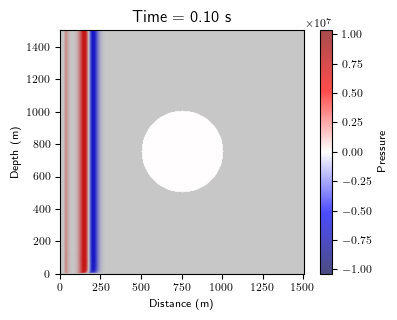

In [3]:
pressure_min, pressure_max = np.min(stored_pressures), np.max(stored_pressures)
time = 1000 * DELTAT  # Calcular el tiempo correspondiente al paso 1000
plt.imshow(kappa_unrelaxed, aspect=1, cmap='gist_yarg', alpha=0.7, extent=[0, NX * DELTAX, 0, NY * DELTAY])
plt.imshow(stored_pressures[1000], aspect=1, cmap='seismic', alpha=0.7, vmin=-pressure_max, vmax=pressure_max, extent=[0, NX * DELTAX, 0, NY * DELTAY])
plt.title(f'Time = {time:.2f} s')
plt.xlabel('Distance (m)')
plt.ylabel('Depth (m)')
plt.colorbar(label='Pressure')
plt.show()

In [4]:
# Lista para almacenar los cuadros del GIF
frames = []

# Crear los cuadros del GIF
for step in range(0, NSTEP, 200):
    time = step * DELTAT  # Calcular el tiempo correspondiente al paso actual
    fig, ax = plt.subplots()
    ax.imshow(kappa_unrelaxed, aspect=1, cmap='gist_yarg', alpha=0.7, extent=[0, NX * DELTAX, 0, NY * DELTAY])
    ax.imshow(stored_pressures[step], aspect=1, cmap='seismic', alpha=0.7, vmin=-pressure_max, vmax=pressure_max, extent=[0, NX * DELTAX, 0, NY * DELTAY])
    ax.set_title(f'Time = {time:.2f} s')
    ax.set_xlabel('z (m)')
    ax.set_ylabel('y (m)')
    plt.colorbar(ax.imshow(stored_pressures[step], aspect=1, cmap='seismic', alpha=0.7, vmin=-pressure_max, vmax=pressure_max, extent=[0, NX * DELTAX, 0, NY * DELTAY]), ax=ax, label='Pressure')   
    # Guardar el cuadro en la lista
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(image)
    plt.close(fig)

# Guardar los cuadros como un GIF
imageio.mimsave('pressure_evolution.gif', frames, fps=5)

/tmp/ipykernel_25380/1742241335.py:16: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
